<a href="https://colab.research.google.com/github/zougoma/dog-breeds-classifier/blob/main/dog_breeds_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
!wget -O ~/.kaggle/kaggle.json https://raw.githubusercontent.com/zougoma/dog-breeds-classifier/main/kaggle.json

--2023-05-14 14:04:17--  https://raw.githubusercontent.com/zougoma/dog-breeds-classifier/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69 [text/plain]
Saving to: ‘/root/.kaggle/kaggle.json’

/root/.kaggle/kaggl 100%[===================>]      69  --.-KB/s    in 0s      

2023-05-14 14:04:17 (4.35 MB/s) - ‘/root/.kaggle/kaggle.json’ saved [69/69]



In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset
!kaggle datasets download -d xhlulu/densenet-keras
!kaggle datasets download -d gaborfodor/keras-pretrained-models

 97% 729M/750M [00:04<00:00, 198MB/s]
100% 750M/750M [00:04<00:00, 186MB/s]
 96% 355M/371M [00:03<00:00, 107MB/s] 
100% 371M/371M [00:03<00:00, 107MB/s]
100% 943M/943M [00:06<00:00, 210MB/s]
100% 943M/943M [00:06<00:00, 145MB/s]


In [8]:
ls

densenet-keras.zip  keras-pretrained-models.zip  stanford-dogs-dataset.zip
drive/              sample_data/


In [9]:
!mkdir Dataset

In [10]:
ls

Dataset/            drive/                       sample_data/
densenet-keras.zip  keras-pretrained-models.zip  stanford-dogs-dataset.zip


In [11]:
!cp /content/densenet-keras.zip /content/Dataset/densenet-keras.zip
!cp /content/keras-pretrained-models.zip /content/Dataset/keras-pretrained-models.zip
!cp /content/stanford-dogs-dataset.zip /content/Dataset/stanford-dogs-dataset.zip

In [12]:
!unzip -q /content/Dataset/densenet-keras.zip -d /content/Dataset
!unzip -q /content/Dataset/keras-pretrained-models.zip -d /content/Dataset
!unzip -q /content/Dataset/stanford-dogs-dataset.zip -d /content/Dataset

In [13]:
!rm /content/Dataset/densenet-keras.zip
!rm /content/Dataset/keras-pretrained-models.zip
!rm /content/Dataset/stanford-dogs-dataset.zip

# how many breeds and pictures we have

In [14]:
breed_list = os.listdir("/content/Dataset/images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("/content/Dataset/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


# label strings and numbers mapping

In [15]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

# show some pictures

In [16]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "/content/Dataset/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    rows = int(n_to_show/4) + 1 if n_to_show % 4 != 0 else int(n_to_show/4)
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(rows, 4, i+1)
        plt.imshow(img)
        plt.axis('off')


n02101388-Brittany_spaniel


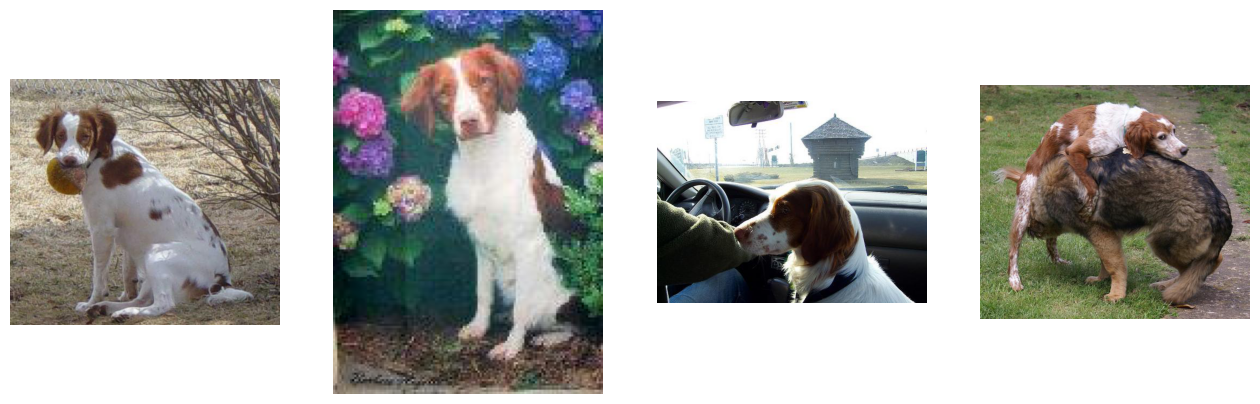

In [17]:
print(breed_list[5])
show_dir_images(breed_list[5], 4)

# crop and save pictures

In [18]:
%%time
# reduce the background noise
os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('/content/Dataset/annotations/Annotation/{}'.format(breed)):
        img = Image.open('/content/Dataset/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('/content/Dataset/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.
CPU times: user 2min 20s, sys: 2.73 s, total: 2min 22s
Wall time: 2min 24s


# prepare X and y

In [19]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

# image generator with augment

In [20]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

# train test split

In [21]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

# keras pretrain densenet121 model

In [22]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="/content/Dataset/DenseNet-BC-121-32-no-top.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

# only train our last 6 layers

In [23]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [24]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [25]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20)

Epoch 1/20
547/547 [==============================] - 114s 177ms/step - loss: 3.2964 - acc: 0.2018 - val_loss: 1.3670 - val_acc: 0.6093
Epoch 2/20
547/547 [==============================] - 92s 168ms/step - loss: 2.1388 - acc: 0.3998 - val_loss: 1.1083 - val_acc: 0.6722
Epoch 3/20
547/547 [==============================] - 91s 167ms/step - loss: 1.9306 - acc: 0.4462 - val_loss: 0.9700 - val_acc: 0.7175
Epoch 4/20
547/547 [==============================] - 90s 165ms/step - loss: 1.8133 - acc: 0.4810 - val_loss: 0.9370 - val_acc: 0.7104
Epoch 5/20
547/547 [==============================] - 91s 166ms/step - loss: 1.7510 - acc: 0.4980 - val_loss: 0.9182 - val_acc: 0.7259
Epoch 6/20
547/547 [==============================] - 91s 166ms/step - loss: 1.6830 - acc: 0.5168 - val_loss: 0.8541 - val_acc: 0.7396
Epoch 7/20
547/547 [==============================] - 91s 166ms/step - loss: 1.6589 - acc: 0.5168 - val_loss: 0.8459 - val_acc: 0.7421
Epoch 8/20
547/547 [==============================] - 

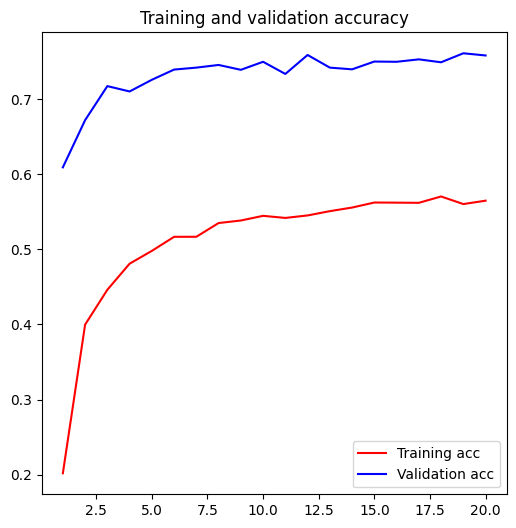

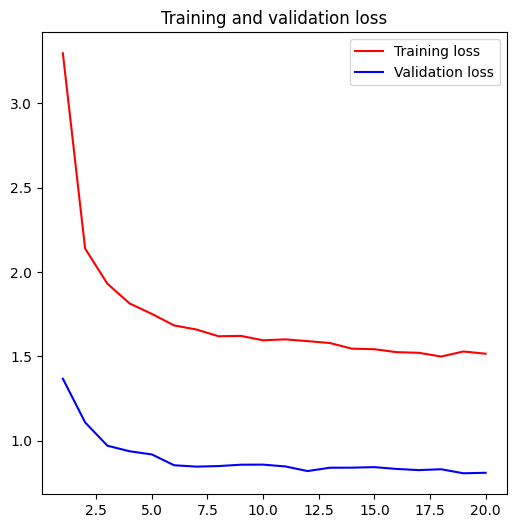

In [26]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

# now train all layers

In [27]:
for layer in model.layers[:]:
    layer.trainable = True

In [28]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [29]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 1.5090 - acc: 0.5706
Epoch 1: val_acc improved from -inf to 0.75510, saving model to dog_breed_classifier_model.h5
547/547 [==============================] - 92s 168ms/step - loss: 1.5090 - acc: 0.5706 - val_loss: 0.8158 - val_acc: 0.7551 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 1.5026 - acc: 0.5707
Epoch 2: val_acc did not improve from 0.75510

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
547/547 [==============================] - 89s 163ms/step - loss: 1.5026 - acc: 0.5707 - val_loss: 0.8332 - val_acc: 0.7525 - lr: 0.0010
Epoch 3/20
547/547 [==============================] - ETA: 0s - loss: 1.3063 - acc: 0.6174
Epoch 3: val_acc improved from 0.75510 to 0.77616, saving model to dog_breed_classifier_model.h5
547/547 [==============================] - 91s 165ms/step - loss: 1.3063 - acc: 0.6174 - val_loss: 0.7226 - val_acc: 0.7762 - lr: 2.0000e-

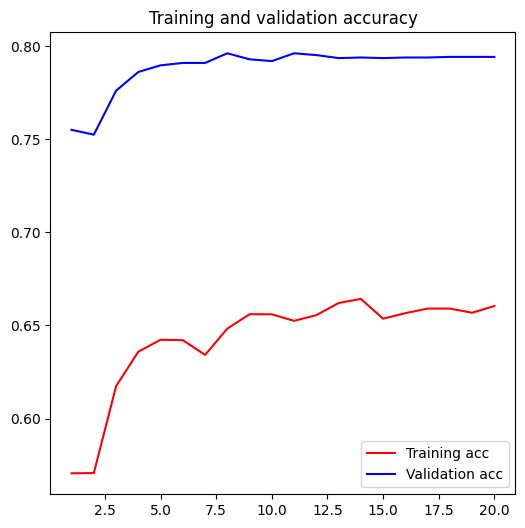

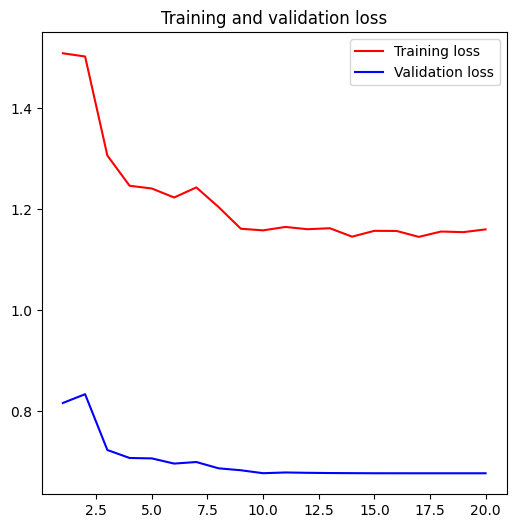

In [30]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [31]:
print(max(val_acc))

0.7962422966957092


# predict new images

download some dog images from pixabay for testing

In [32]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

1/1 [==============================] - 3s 3s/step
58.10% 	 malinois
19.22% 	 dingo
11.86% 	 dhole
6.51% 	 German_shepherd
3.81% 	 kelpie


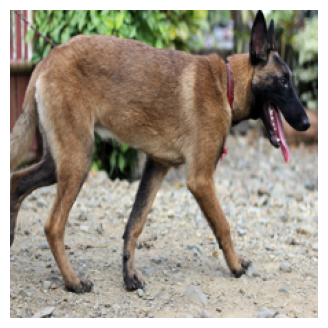

In [33]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")

1/1 [==============================] - 0s 33ms/step
90.06% 	 Pembroke
9.89% 	 Cardigan
0.01% 	 Chihuahua
0.01% 	 basenji
0.01% 	 dingo


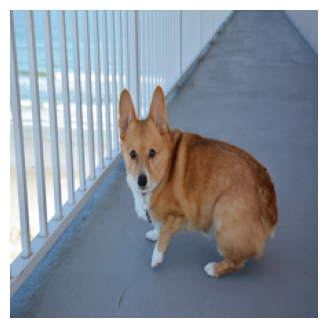

In [34]:
download_and_predict("https://cdn.pixabay.com/photo/2016/07/25/00/06/corgi-1539598_1280.jpg",
                     "test_2.jpg")

1/1 [==============================] - 0s 31ms/step
98.43% 	 Chihuahua
1.27% 	 toy_terrier
0.20% 	 miniature_pinscher
0.07% 	 Boston_bull
0.03% 	 Pembroke


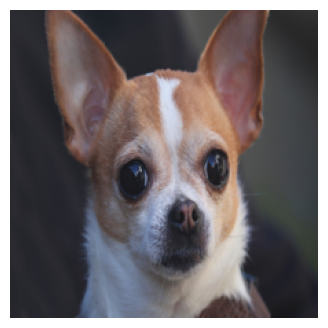

In [35]:
download_and_predict("https://cdn.pixabay.com/photo/2019/02/24/20/15/chihuahua-4018429_1280.jpg",
                     "test_3.jpg")

1/1 [==============================] - 0s 32ms/step
48.97% 	 redbone
22.39% 	 Rhodesian_ridgeback
18.11% 	 vizsla
6.40% 	 Weimaraner
0.75% 	 Italian_greyhound


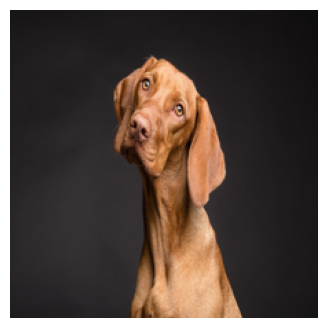

In [36]:
download_and_predict("https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
                     "test_4.jpg")

1/1 [==============================] - 0s 31ms/step
97.52% 	 Labrador_retriever
1.72% 	 golden_retriever
0.40% 	 Chesapeake_Bay_retriever
0.20% 	 Rhodesian_ridgeback
0.04% 	 bull_mastiff


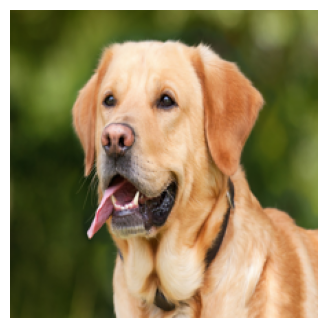

In [37]:
download_and_predict("https://cdn.pixabay.com/photo/2016/02/19/15/46/dog-1210559_1280.jpg",
                     "test_5.jpg")

# cleaning

In [38]:
!rm -rf data/* 

In [39]:
!rm -f test_*.jpg